# Challenge: Clasificación de enfermedades oculares en imagenes de fondo de ojo

### Realizado por: 
1. Martín Cortés
2. Laura Escobedo
3. Valentina Muriel
4. Juan Felipe Daza

### Contexto

Las enfermedades oculares pueden comprometer de forma significativa la visión y calidad de vida de quienes las padecen, especialmente cuando no se detectan a tiempo. Muchas de estas patologías afectan estructuras clave del fondo de ojo, como el nervio óptico, la mácula o los vasos sanguíneos, cuya evaluación es fundamental para un diagnóstico oportuno.

El examen de fondo de ojo mediante imágenes retinianas es un procedimiento no invasivo que permite visualizar dichas estructuras con alta precisión. En la práctica clínica, los especialistas analizan estas imágenes en busca de signos característicos de patologías como glaucoma, cataratas, degeneración macular asociada a la edad, entre otras. Sin embargo, esta evaluación depende en gran medida de la experiencia del médico, y está sujeta a variabilidad entre observadores.

Debido a la creciente disponibilidad de imágenes retinianas etiquetadas, se ha abierto la posibilidad de desarrollar sistemas automatizados de clasificación mediante técnicas de aprendizaje profundo. Estos sistemas buscan asistir en la detección simultánea de múltiples enfermedades, reduciendo la subjetividad del diagnóstico y mejorando la eficiencia y confiabilidad del proceso clínico.

### Dataset

Con este fin, se recopiló un conjunto de imágenes de fondo de ojo provenientes de pacientes con distintas afecciones oftalmológicas, con el objetivo de desarrollar modelos de aprendizaje profundo para la clasificación automática de enfermedades oculares.

El dataset está conformado por un total de 7255 imágenes, divididas en 5078 imágenes para entrenamiento, 1088 para validación y 1089 para prueba. Cada imagen ha sido anotada con una única etiqueta diagnóstica correspondiente a una de las siguientes cinco categorías clínicas:

* Normal (Ojo Sano)
* Diabetes (retinopatia diabetica)
* Cataract (Cataratas)
* Myopia
* Glaucoma

El conjunto de datos se organiza en tres carpetas, cada una de un respectivo subset, y alberga las imágenes de fondo de ojo junto a un archivo ".csv" que contienen las anotaciones correspondientes a cada imagen.

El conjunto de prueba tan solo contiene las imágenes sin el archivo de anotaciones. 

A continuación se muestra una pequeña muestra aleatoria de las imágenes del conjunto de entrenamiento, sin emabrgo, se recomienda realizar una exploración más profunda de estos para obtener un entendimiento de los datos más claro. 

In [25]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

from utils.color import Color
from utils.shape import Shape
from utils.dataset import Dataset
from utils.texture import Texture
from utils.features import Features

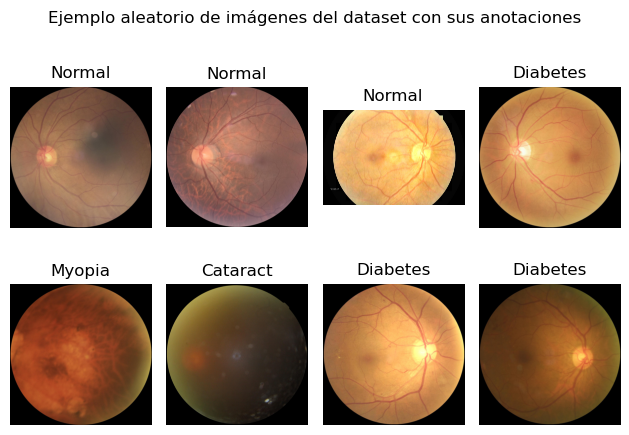

In [ ]:
csv_data = pd.read_csv(os.path.join("ChallengeDataset","train", "train.csv"))
image_paths = [os.path.join("ChallengeDataset", "train", name) for name in csv_data['ID'].values]
labels = np.argmax(csv_data.iloc[:, 1:].values, axis=1)
category_names = csv_data.columns[1:].tolist()

random_indices = np.random.choice(len(image_paths), 8, replace=False)
images_to_display = [image_paths[i] for i in random_indices]
labels_to_display = [labels[i] for i in random_indices]

rows = 2
cols = 4
fig, ax = plt.subplots(rows,cols, layout='tight')

k = 0
for i in range(rows):
    for j in range(cols):
        image = cv2.imread(images_to_display[k], cv2.IMREAD_COLOR_RGB)
        label = category_names[labels_to_display[k]]
        ax[i, j].imshow(image)
        ax[i, j].set(title=label)
        ax[i, j].axis('off')
        k+=1

plt.suptitle("Ejemplo aleatorio de imágenes del dataset con sus anotaciones")
plt.show()

### Baseline

Como un primer acercamiento a este problema se propone una línea de base fundamentada en los conceptos de Machine Learning. Tras una experimentación exahustiva con diversos clasificadores y descriptores de imágenes se obtuvo que el clasificador con el mayor desempeño fue una máquina de soporte vectorial con un descriptor de imágenes multimodal que combina información de color, forma, y textura.    

Específicamente, el f1-score macro de este modelo en el conjunto de validación fue de $0.58$, mientras que en el conjunto de prueba alcanzó un valor de $0.56$.

A continuación se presenta la implemntación de este modelo: 

In [ ]:
dataset = Dataset("ChallengeDataset")

color = Color(
    image_size=(256, 256),
    color_space="rgb",
    pyramid=True,
    pacth_sizes=[(256, 256), (128, 128), (64, 64)],
    hist_type="joint",
    bins=6,
)
shape = Shape(
    image_size=(224, 224),
    orientations=9,
    pixels_per_cell=(32, 32),
    cells_per_block=(3, 3),
)
texture = Texture(
    filterbank=os.path.join("utils", "filterbank.mat"),
    textons=30,
    random_state=0,
    img_size=(256, 256),
    pyramid=True,
    pacth_sizes=[(256, 256), (128, 128), (64, 64)],
)

print("Creating dictionary of textons")
Im_list = [cv2.imread(path) for path, _ in tqdm(dataset.train[:24], desc="Loading images")]
texture.create_dictionary_of_textons(Im_list)

features = Features(color, shape, texture)
train, valid, test = features(dataset)

Creating dictionary of textons


Filtering images: 100%|██████████| 24/24 [00:21<00:00,  1.10it/s]


Extracting features from train split


Extracting shape features: 100%|██████████| 5078/5078 [00:28<00:00, 181.00it/s]


Extracting features from valid split


Extracting shape features: 100%|██████████| 1088/1088 [00:06<00:00, 158.11it/s]


Extracting features from test split


Extracting shape features: 100%|██████████| 1089/1089 [00:07<00:00, 154.84it/s]


In [28]:
svm = cv2.ml.SVM_create()
svm.setKernel(cv2.ml.SVM_RBF)
svm.setType(cv2.ml.SVM_C_SVC)
svm.setC(4)
svm.setGamma(0.125)

svm.train(np.array(train['color_shape_texture'], dtype=np.float32), cv2.ml.ROW_SAMPLE, np.array(train["labels"], dtype=np.int32))                                   

True

### Evaluación baseline
#### Conjunto validación

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       610
           1       0.43      0.52      0.47       320
           2       0.88      0.64      0.74        47
           3       0.94      0.83      0.88        54
           4       0.62      0.09      0.15        57

    accuracy                           0.60      1088
   macro avg       0.71      0.55      0.58      1088
weighted avg       0.61      0.60      0.59      1088



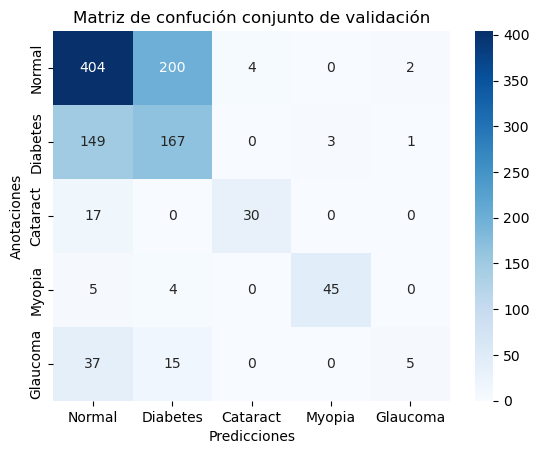

In [29]:
retval, predict_svm = svm.predict(np.array(valid['color_shape_texture'], dtype=np.float32))
print(classification_report(np.array(valid["labels"], dtype=np.int32), predict_svm))


cm = confusion_matrix(np.array(valid["labels"], dtype=np.int32), predict_svm)
classes = np.array([f"{category_names[i]}" for i in range(5)])
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, )
ax.set_xlabel("Predicciones")
ax.set_ylabel("Anotaciones")
ax.set_title("Matriz de confución conjunto de validación")
plt.show()

### Método Final 

Para el método final cada grupo deberá utilizar los conocimientos brindados en el curso para construir un modelo de clasificación que permita determinar la categoria patologica a partir de imágenes de fondo de ojo. Para esto, cada grupo puede utilizar cualquier método de aprendizaje automático supervisado, así como cualquier descriptor de imagen que considere pertinente y otras técnicas que quieran para mejorar el desempeño de su modelo.  Además, se debe realizar una experimentación exhaustiva de hiperparámetros para mejorar el desempeño del modelo final, optimizando sobre los datos de validación. 

El objetivo del método final será superar el desempeño del modelo de baseline proporcionado, en específico la métrica de f1-score macro sobre el conjunto de prueba. 

Para evaluar la eficacia de los modelos finales de cada equipo, se compararán las predicciones hechas por estos. Por lo tanto, una vez que hayan perfeccionado su modelo, cada equipo deberá predecir las etiquetas de las imágenes en el conjunto de prueba.

In [30]:
# Modelo super wow 

### Entregables

En los archivos adjuntos al Challenge se incluye `TestPredictionsEmpty.csv`. Este archivo consta de dos columnas: la primera con el nombre de cada imagen del conjunto de prueba y la segunda con un valor predeterminado de _NaN_. Cada grupo deberá completar este archivo, reemplazando el valor _NaN_ de cada imagen con la predicción de patologia ("Normal", "Diabetes", "Cataract", "Myopia" o "Glaucoma") generada por su modelo, y guardarlo como `TestPredictions.csv`. Este último archivo será utilizado para evaluar el desempeño de cada modelo mediante su comparación con las anotaciones reales. 

In [31]:
#Ejemplo de cómo cargar el archivo "TestPredictionsEmpty.csv" y cómo llenarlo 

test_predictions_empty = pd.read_csv("TestPredictionsEmpty.csv")

retval, predict_svm_test = svm.predict(np.array(test['color_shape_texture'], dtype=np.float32)) #Cambiar por método final
test_predictions_empty["Labels"] = classes[predict_svm_test.astype(np.int8)] #Cambiar por método final
test_predictions_empty.to_csv("TestPredictions.csv") 

De manera que el entregable de este Challenge es un archivo `.zip` que contiene: 
1. Archivo `TestPredictions.csv` que contiene la categoria predicho por el método final.
2. Un cuaderno de Jupyter `MetodoFinalGrupoX.ipynb` done _X_ corresponde al número del grupo y contiene el código con la implementación del método final de dicho grupo. 

### Evaluación
La evaluación del Challenge se realizará con el archivo `TestPredictions.csv` que deberá contener la patologia predicha por el método final para el conjunto de prueba. Para esto, se utilizarán las métricas de evaluación cuantitativa de clasificación: precisión, recall y F1-score y se compararán con las métricas obtenidas por el modelo de baseline. Todos los grupos que superen la métrica $\textbf{F1-score de prueba}$ $(0.56)$ del baseline tendrán un bono en la nota final del curso, donde el grupo que obtenga el mejor desempeño en la métrica de $\textbf{prueba}$ tendrá +0.5 puntos y a partir de este se irá disminuyendo el bono hasta 0.1 punto para el grupo con el peor despeño por encima del baseline. 

A continuación se presenta el código que se utilizará para evaluar el desempeño del método final, en particular los resultados que se observan inicialmente son los del Baseline. 

Cabe resaltar que el archivo `TestAnnotations.csv` no estará disponible durante la realización del Challenge, por lo que es de esperar que al ejecutar la siguiente celda se genere un error. 

              precision    recall  f1-score   support

           0       0.64      0.63      0.64       619
           1       0.40      0.48      0.43       310
           2       0.77      0.71      0.74        62
           3       0.95      0.85      0.90        46
           4       0.50      0.06      0.10        52

    accuracy                           0.58      1089
   macro avg       0.65      0.55      0.56      1089
weighted avg       0.59      0.58      0.57      1089



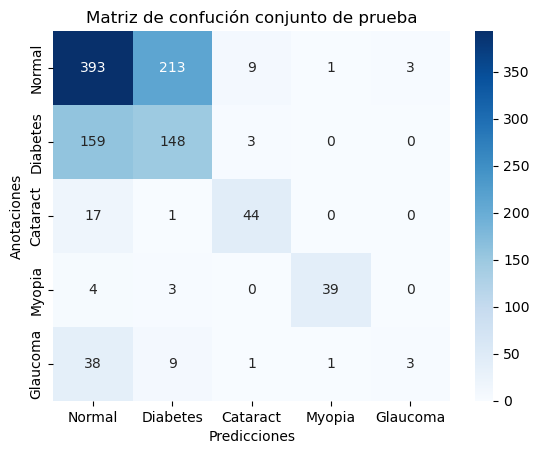

In [32]:
test_annotations = pd.read_csv("TestAnnotations.csv")
test_predictions = pd.read_csv("TestPredictions.csv")
name_map = {category_names[i]: i for i in range(5)}
test_annotations["Labels"] = test_annotations["Labels"].map(name_map)
test_predictions["Labels"] = test_predictions["Labels"].map(name_map)
print(classification_report(test_annotations["Labels"], test_predictions["Labels"]))

cm = confusion_matrix(test_annotations["Labels"], test_predictions["Labels"])
classes = [f"{category_names[i]}" for i in range(5)]
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, )
ax.set_xlabel("Predicciones")
ax.set_ylabel("Anotaciones")
ax.set_title("Matriz de confución conjunto de prueba")
plt.show()